In [1]:
# -----------------------------
# Cell 1: Setup paths
# -----------------------------
import sys
from pathlib import Path

# Notebook location
notebook_path = Path().resolve()  # current notebook folder
project_root = notebook_path.parent.parent  # Notebook/ -> project root
src_path = project_root / "src"


# Current notebook folder
notebook_path = Path().resolve()


# Add to Python path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Notebook path:", notebook_path)
print("Project root:", project_root)
print("SRC path:", src_path)

Notebook path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\notebooks\analysis
Project root: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics
SRC path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src


In [2]:
# Basic imports
import pandas as pd
import logging

# Project modules
from fintech_app_reviews.config import load_config
from fintech_app_reviews.nlp.sentiment import aggregate_sentiment
from fintech_app_reviews.nlp.keywords import extract_tfidf_keywords_per_group, attach_top_keywords_to_df
from fintech_app_reviews.nlp.themes import compile_keyword_patterns, rule_assign_themes,preprocess_text
from fintech_app_reviews.nlp.sentiment_bert import annotate_dataframe_parallel
from fintech_app_reviews.viz.plots import plot_ratings_per_bank, plot_sentiment_per_bank, plot_theme_distribution
# Logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

d:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Config path at project root
config_path = project_root / "configs" / "nlp.yaml"

# Load NLP config
nlp_cfg = load_config(config_path)

print("Config path:", config_path)

# Load cleaned reviews
df = pd.read_csv(project_root / "data/interim/clean_reviews.csv")

# Optional: add review_id if missing
if "review_id" not in df.columns:
    df["review_id"] = range(1, len(df) + 1)
print(f"Loaded {len(df)} reviews")
df.head()

Config path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\configs\nlp.yaml
Loaded 1374 reviews


,review,rating,date,bank,source,review_id
0,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia (CBE),google_play,1
1,this application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,2
2,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,3
3,the app makes our life easier. thank you cbe!,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,4
4,the most advanced app. but how to stay safe?,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,5


In [4]:
# -------------------------
# Clean text
# -------------------------
df["txt_clean"] = df["review"].apply(preprocess_text)

df[["review", "txt_clean"]].head()


,review,txt_clean
0,it's special for me,special
1,this application is very important and advanta...,application important advantage transfer money...
2,why didn't work this app?,work app
3,the app makes our life easier. thank you cbe!,app make life easier thank cbe
4,the most advanced app. but how to stay safe?,advanced app stay safe


In [5]:
# Annotate with sentiment
df = annotate_dataframe_parallel(
    df,
    text_col="txt_clean",
    max_workers=4,
    batch_size=32
)

# Verify coverage
coverage = df["sentiment_label"].notna().mean()
logger.info("Sentiment coverage: %.2f%%", coverage * 100)
assert coverage >= 0.9, "Sentiment coverage below 90%"

Device set to use cpu
INFO:fintech_app_reviews.nlp.sentiment_bert:Sentiment coverage: 100.00%
INFO:__main__:Sentiment coverage: 100.00%


In [6]:
df.head()

,review,rating,date,bank,source,review_id,txt_clean,sentiment_label,sentiment_score
0,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia (CBE),google_play,1,special,positive,0.999722
1,this application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,2,application important advantage transfer money...,positive,0.732493
2,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,3,work app,positive,0.978127
3,the app makes our life easier. thank you cbe!,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,4,app make life easier thank cbe,positive,0.998261
4,the most advanced app. but how to stay safe?,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,5,advanced app stay safe,positive,0.945463


In [7]:
# Extract manual rules from YAML
theme_rules = nlp_cfg["themes"].get("rules", [])

# Build a dict like theme_map
theme_map = {rule["name"]: rule["keywords"] for rule in theme_rules}

compiled_map = compile_keyword_patterns(theme_map)

logger.info("Compiled theme patterns from YAML")

INFO:__main__:Compiled theme patterns from YAML


In [8]:


# Extract top 50 TF-IDF keywords per bank
top_keywords_per_bank = extract_tfidf_keywords_per_group(
    df,
    text_col="txt_clean",
    group_col="bank",
    top_n=50,
    ngram_range=(1, 2),
    min_df=2,
    max_features=5000
)

# Optional: attach top keywords to each review
# Flatten global list for annotation
global_keywords = sorted(
    {kw for kws in top_keywords_per_bank.values() for kw in kws})
df = attach_top_keywords_to_df(
    df, text_col="txt_clean", global_tfidf=global_keywords, top_k=5)
df[["review", "keywords"]].head(3)

,review,keywords
0,it's special for me,
1,this application is very important and advanta...,money|transfer|application
2,why didn't work this app?,app|work


In [9]:
def safe_assign_themes(text: str, compiled_map=compiled_map):
    """Return a list of matched themes for a given review."""
    if not isinstance(text, str) or not text.strip():
        return []
    try:
        themes = rule_assign_themes(text, compiled_map)
        return list(dict.fromkeys(themes))   # remove duplicates, keep order
    except Exception as e:
        logger.warning("Theme assignment failed: %s", e)
        return []


# Apply rule-based themes
df["themes"] = df["keywords"].apply(safe_assign_themes)


# Expand themes into structured fields
def explode_theme_fields(theme_list):
    if not theme_list:
        return pd.Series({
            "theme_primary": None,
            "theme_secondary": None,
            "all_themes": ""
        })

    return pd.Series({
        "theme_primary": theme_list[0],
        "theme_secondary": theme_list[1] if len(theme_list) > 1 else None,
        "all_themes": ";".join(theme_list)
    })


df[["theme_primary", "theme_secondary", "all_themes"]] = (
    df["themes"].apply(explode_theme_fields)
)

df.head()


,review,rating,date,bank,source,review_id,txt_clean,sentiment_label,sentiment_score,keywords,themes,theme_primary,theme_secondary,all_themes
0,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia (CBE),google_play,1,special,positive,0.999722,,[],None,None,
1,this application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,2,application important advantage transfer money...,positive,0.732493,money|transfer|application,[Transaction Performance],Transaction Performance,None,Transaction Performance
2,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,3,work app,positive,0.978127,app|work,[],None,None,
3,the app makes our life easier. thank you cbe!,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,4,app make life easier thank cbe,positive,0.998261,app|cbe|life|make|thank,[],None,None,
4,the most advanced app. but how to stay safe?,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play,5,advanced app stay safe,positive,0.945463,app,[],None,None,


In [10]:
# Save full dataset already done above
theme_path = project_root / nlp_cfg["output"]["themes_path"]
df.to_csv(theme_path, index=False)
logger.info("Theme results saved to %s", theme_path)


# -----------------------------
# Save per-bank outputs
# -----------------------------
per_bank_dir = project_root / nlp_cfg["output"]["themes_per_bank_dir"]
per_bank_dir.mkdir(parents=True, exist_ok=True)

for bank, gdf in df.groupby("bank"):
    out_path = per_bank_dir / f"{bank}_themes.csv"
    gdf.to_csv(out_path, index=False)
    logger.info("Saved per-bank theme results: %s", out_path)

INFO:__main__:Theme results saved to D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\reviews_with_themes.csv
INFO:__main__:Saved per-bank theme results: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\per_bank\Bank of Abyssinia (BOA)_themes.csv
INFO:__main__:Saved per-bank theme results: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\per_bank\Commercial Bank of Ethiopia (CBE)_themes.csv
INFO:__main__:Saved per-bank theme results: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\per_bank\Dashen Bank_themes.csv


In [11]:
# -------------------------
# Aggregate sentiment per bank/rating
# -------------------------
import hashlib
agg_df = aggregate_sentiment(df, group_cols=["bank", "rating"])


def generate_review_id(row):
    raw = f"{row['bank']}|{row['review']}|{row['date']}"
    return hashlib.md5(raw.encode("utf-8")).hexdigest()


df["review_id"] = df.apply(generate_review_id, axis=1)


enriched_output_path = project_root / \
    nlp_cfg["output"].get(
        "enriched_output_path")

df.to_csv(enriched_output_path, index=False)
logger.info("Saved aggregated sentiment results to %s", enriched_output_path)
agg_df.head()

INFO:__main__:Saved aggregated sentiment results to D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\nlp_enriched_reviews.csv


,bank,rating,mean_sentiment_score,positive_count,negative_count,neutral_count
0,Bank of Abyssinia (BOA),1,-0.561506,49,171,0
1,Bank of Abyssinia (BOA),2,-0.280496,9,16,0
2,Bank of Abyssinia (BOA),3,0.033160,17,16,0
3,Bank of Abyssinia (BOA),4,0.324599,15,8,0
4,Bank of Abyssinia (BOA),5,0.636402,151,34,0


In [14]:
# Top 10 keywords per bank
for bank, kws in top_keywords_per_bank.items():
    print(f"{bank} top keywords: {kws[:10]}")

Bank of Abyssinia (BOA) top keywords: ['good', 'app', 'best', 'nice', 'boa', 'work', 'bank', 'working', 'banking', 'worst']
Commercial Bank of Ethiopia (CBE) top keywords: ['good', 'app', 'best', 'nice', 'cbe', 'bank', 'use', 'application', 'good app', 'like']
Dashen Bank top keywords: ['good', 'app', 'best', 'bank', 'nice', 'wow', 'dashen', 'easy', 'use', 'fast']


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


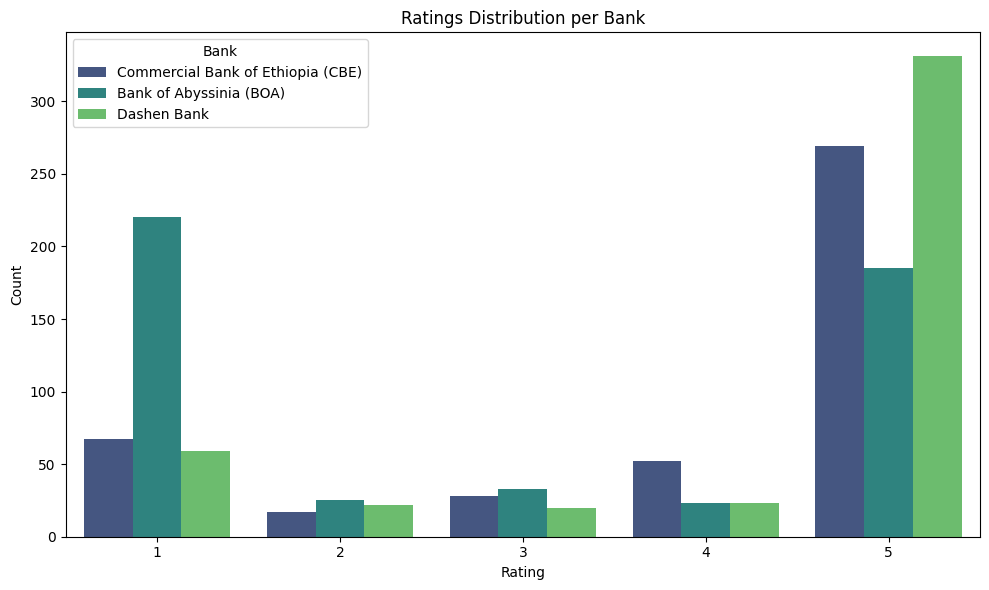

D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src\fintech_app_reviews\viz\plots.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=bank_col, y=score_col, palette=palette)


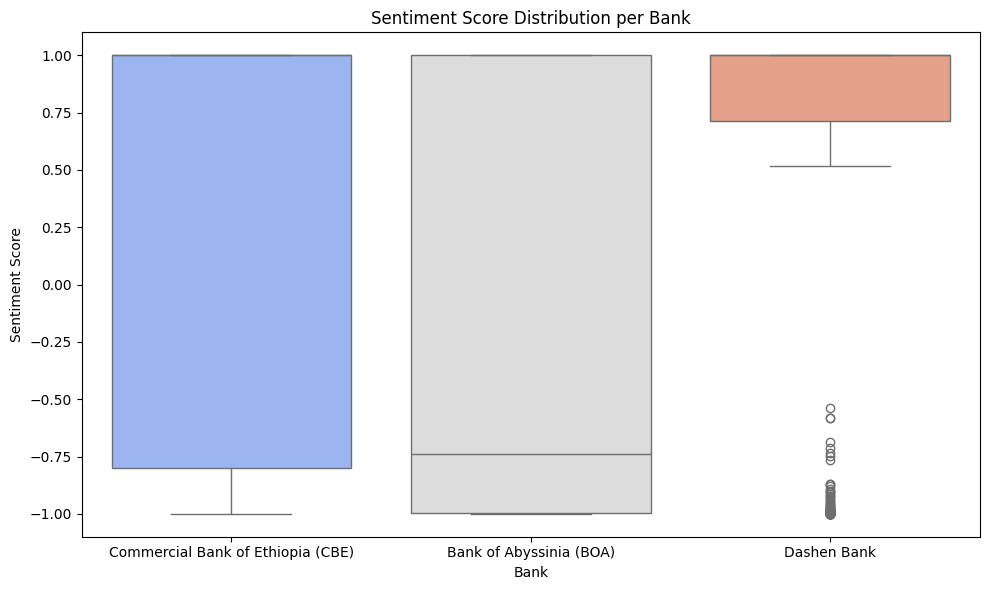

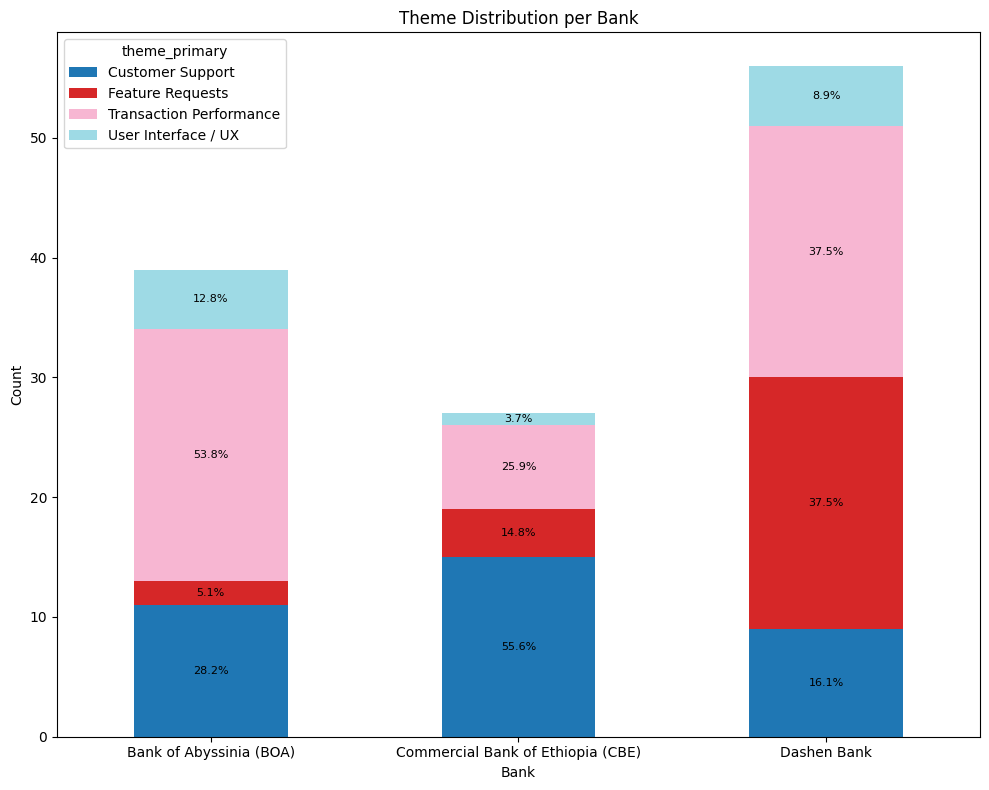

In [16]:
plot_ratings_per_bank(df)
plot_sentiment_per_bank(df)
plot_theme_distribution(df)